# Table of Contents

* [Imports](#Imports)
* [Utility Functions](#Utility-Functions)
    * [Simulator](#Simulator)
    * [Prior Distribution](#Prior-Distribution)
    * [True Parameter Value](#True-Parameter-Value)
    * [Proposal Distribution](#Proposal-Distribution)
    * [Classifier](#Classifier)
* [Training the Classifier](#Training-the-Classifier)
    * [Generate Training Data](#Generate-Training-Data)
    * [Training Settings](#Training-Settings)
    * [Optimizer](#Optimizer)
    * [Training Loop](#Training-Loop)
* [MCMC](#MCMC)
    * [One Datapoint: Generate Data](#One-Datapoint:-Generate-Data)
    * [One Datapoint: RWMH function](#One-Datapoint:-RWMH-function)
    * [One Datapoint: Running the MCMC](#One-Datapoint:-Running-the-MCMC)

# Imports

In [1]:
import torch
from torch.nn import Linear, BCEWithLogitsLoss, BCELoss
from torch.optim import Adam
import torch.nn.functional as F
from torch.distributions import MultivariateNormal, Uniform
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Utility Functions

### Simulator

In [2]:
def generate(theta):
    """Generator, samples x ~ p(x|theta) given a theta.Here theta is a torch.Tensor of size (1, 5).
    I flatten it just so that it is easier to extract its components."""
    # Flatten theta
    theta = theta.flatten()
    # Parameters for Covariance Matrix
    s1, s2 = theta[2]**2, theta[3]**2
    rho = theta[4].tanh()
    # Find Mean and Covariance for N( , )
    mean = torch.tensor([theta[0], theta[1]])
    covariance = torch.tensor([
        [s1**2, rho*s1*s2],
        [rho*s1 * s2, s2**2]])
    return MultivariateNormal(mean, covariance).sample(torch.Size([4])).view(1, -1)

### Prior Distribution

In [3]:
def prior(size):
    """Samples the prior distribution Uniform(-3, 3) for every one of the 5 elements of theta."""
    return Uniform(low=-3*torch.ones(5), high=3*torch.ones(5)).sample(torch.Size([size]))

def prior_log_prob(theta):
    """Computes log p(theta). This is used to compute the acceptance ratio in MH."""
    return Uniform(low=-3*torch.ones(5), high=3*torch.ones(5)).log_prob(theta).mean()

### True Parameter Value

In [4]:
def truth():
    """True value of the parameter theta"""
    return torch.Tensor([0.7, -2.9, -1.0, -0.9, 0.6])

### Proposal Distribution 

In [5]:
def proposal(theta_current, scale=0.1):
    """Proposal distribution for Metropolis Hastings. This is a Normal Distribution with unit variance, meaning 
    that it will be a Random Walk Metropolis Hastings."""
    return MultivariateNormal(theta_current, torch.eye(5)*scale)

### Classifier

The following classifier distinguishes between dependent $(x, \theta)\sim p(x, \theta)$ and independent $(x, \theta)\sim p(\theta)p(x)$ pairs.

In this case it has $13$ nodes in the input layter because $\theta\in\mathbb{R}^5$ and $x\in\mathbb{R}^8$ so that $(\theta, x)\in\mathbb{R}^{13}$. It then goes through a first fully connected layer with Relu activation function, a second hidden layer with Relu activation function and a third activation layer with a sigmoid activation function. However, for computational reasons, we grab $\log r$ before feeding it through the sigmoid.

In [6]:
class Classifier(torch.nn.Module):
    """Classifier distinguishing (x, theta) ~ p(x, theta) and (x, theta) ~ p(x)p(theta)."""
    def __init__(self):
        """Construct the layers. Note x is 8 dim and theta is 5 dim"""
        super(Classifier, self).__init__()
        # Fully Connected (fc) layers for classifier
        self.fc1 = Linear(in_features=13, out_features=128)
        self.fc2 = Linear(in_features=128, out_features=128)
        self.fc3 = Linear(in_features=128, out_features=128)
        self.fc4 = Linear(in_features=128, out_features=1)

    def forward(self, input):
        """Describes how to get output from input. All fully-connected layers have ReLU activation 
        function except for the last one which has a sigmoid activation function."""
        # Feed through the network
        logr = self.fc4(F.selu(self.fc3(F.selu(self.fc2(F.selu(self.fc1(input)))))))
        return torch.sigmoid(logr), logr

# Training the Classifier

### Generate Training Data

In [7]:
# Number of prior samples to draw (= Number of observations to generate)
n_samples = 100000    

# Sample from prior and generate data
theta_samples = prior(n_samples)                                              # size: (n_samples, 5)
observations = torch.cat([generate(theta) for theta in theta_samples])        # size: (n_samples, 8)

# Dependent dataset
dep = torch.cat((theta_samples, observations), dim=1)                         # size: (n_samples, 13)

# Shuffle theta to generate a new (independent) dataset. Shuffling lowers the variance.
theta_shuffled = theta_samples[torch.randperm(n_samples)]
indep = torch.cat((theta_shuffled, observations), dim=1)

### Training Settings

In [8]:
n_epochs = 250     # Sweeps through dataset
batch_size = 256   # Number of examples used for Stochastic Gradient Descent-like algorithms
train_with_logits = False
if train_with_logits:
    BCEloss = BCEWithLogitsLoss(reduction='sum') 
else:
    BCEloss = BCELoss(reduction='sum') 
average_losses = []   # Will store average epoch losses

### Optimizer

In [9]:
classifier = Classifier()
optimizer = Adam(classifier.parameters(), lr=0.001)

### Training Loop

In [10]:
# Go through dataset n_epochs times
for epoch in range(n_epochs):
     # Keeps track of average loss for this epoch (across data batches)
    running_loss = 0.0    
    
    # Go through batches of data
    for batch in range(n_samples // batch_size):
        
        # Grab (x, theta) pairs in batch. dep_b is the dependent batch of data (batch_size, 13) and indep_b is the 
        # independent batch of data (batch_size, 13)
        dep_b, indep_b = dep[batch*100:(batch+1)*100], indep[batch*100:(batch+1)*100]
        
        # Feed through neural network classifier. Recall NN outputs both d and its logit log(r)
        d_dep, logr_dep = classifier(dep_b)
        d_indep, logr_indep = classifier(indep_b)
        
        # Compute loss by summing dependent and independent loss
        if train_with_logits:
            loss_dep = BCEloss(logr_dep.view(1, -1), torch.ones(1, 100))
            loss_indep = BCEloss(logr_indep.view(1, -1), torch.zeros(1, 100))
        else:
            loss_dep = BCEloss(d_dep.view(1, -1), torch.ones(1, 100))
            loss_indep = BCEloss(d_indep.view(1, -1), torch.zeros(1, 100))
        loss = loss_dep + loss_indep
        
        # Zero the gradients + backward + optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # add loss to average loss counter
        running_loss += loss.item()
        
    # Store average loss
    average_losses.append(running_loss/n_samples)

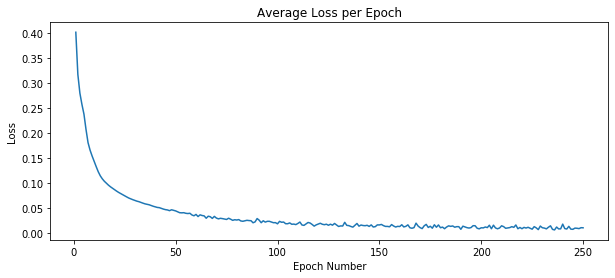

In [11]:
# Show average loss per epoch
avg_loss = np.array(average_losses)
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(np.arange(1, n_epochs+1), avg_loss)
ax.set_title("Average Loss per Epoch")
ax.set_xlabel("Epoch Number")
ax.set_ylabel("Loss")
plt.show()

# MCMC

### One Datapoint: Generate Data

In [12]:
x0 = generate(truth())

### One Datapoint: RWMH function

In [13]:
def rwmh_ratio(theta_start, niter, proposal, classifier, prior_log_prob, x0):
    """RWMH using Ratio Estimation.
    theta_start: Initial theta to start RWMH, theta_0. Has shape (1, 5).
    niter: Number of iterations to run RWMH for.
    proposal: q(theta' | theta_t) used to sample candidate values. In this case a Normal Distribution.
    classifier: Amortized Ratio Estimator NN.
    prior_log_prob: computes logp(theta).
    x0: observation for which we want to sample thetas from its posterior: \theta_1, \ldots, \theta_{niter} ~ p(\theta | x_0)
    """
    # SETUP
    accepted = 0                                                     # Store number of accepted
    samples = torch.empty((niter, 5))                                # Store samples from posterior
    candidates = torch.empty((niter, 5))
    theta_t = theta_start                                            # Set first sample to start 
    logu = Uniform(low=0, high=1).sample(torch.Size([niter])).log()  # Sample log Uniform for acceptance/rejection
    
    # COMPUTE LOG(R) FOR THETA_T
    pair_current = torch.cat((theta_t, x0), dim=1)
    _, logr_current = classifier(pair_current)
    logr_current = logr_current.sum()
    
    for i in range(niter):
        # COMPUTE LOG(R) FOR THETA_CANDIDATE
        candidate = proposal(theta_t).sample()                # Sample from proposal distribution
        candidates[i, ] = candidate
        pair_candidate = torch.cat((candidate, x0), dim=1)
        _, logr_candidate = classifier(pair_candidate)
        logr_candidate = logr_candidate.sum()
        
        # ACCEPT / REJECT
        # Since prior is Uniform, no need to include it here as they cancel out
        if logu[i] <= logr_candidate - logr_current:
            # Accept candidate
            theta_t = candidate
            logr_current = logr_candidate
            accepted += 1                   # update accepted counter
        
        # store the sample
        samples[i, ] = theta_t
        
    # Return samples and acceptance probability
    return samples, accepted / niter, candidates

### One Datapoint: Running the MCMC

In [14]:
# Run the chain
niter=100000
samples, acceptance, candidates = rwmh_ratio(
    theta_start=prior(1),
    niter=niter,
    proposal=proposal, 
    classifier=classifier,
    prior_log_prob=prior_log_prob,
    x0=x0
)

Acceptance: 0.0224


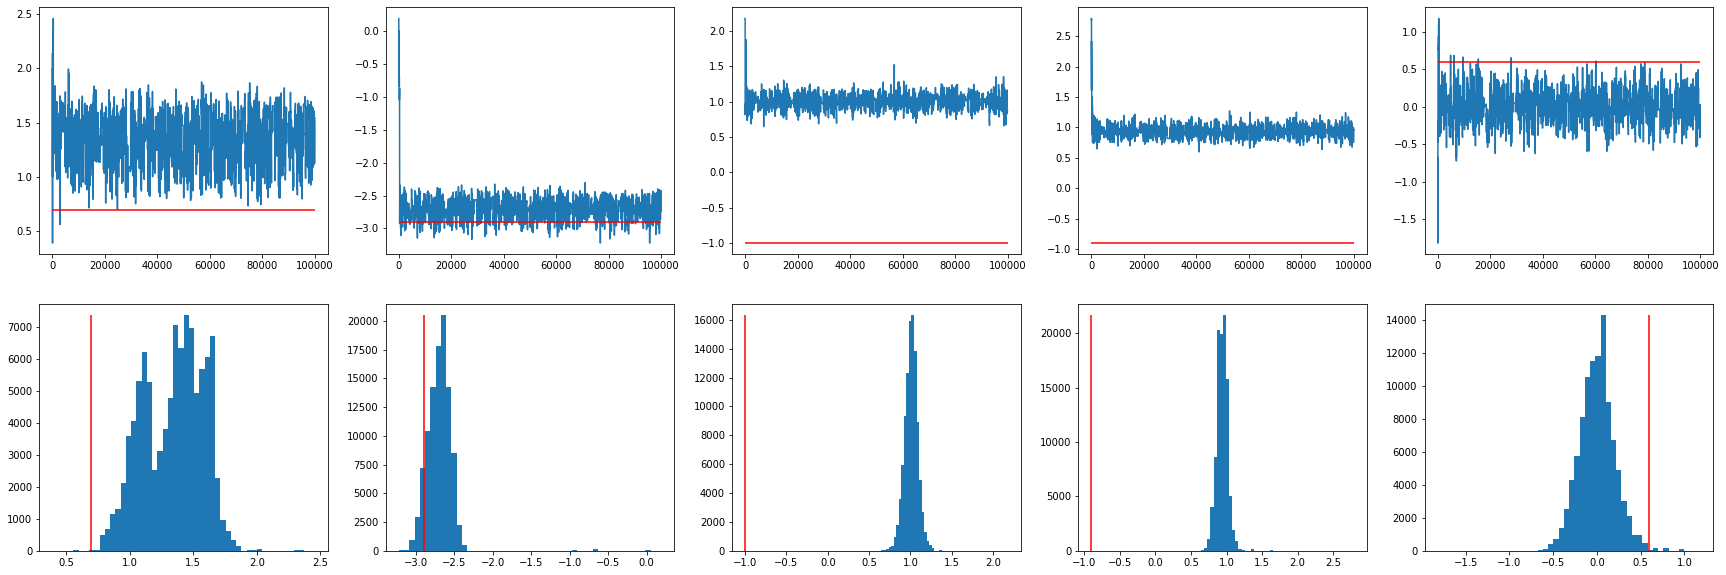

In [15]:
print("Acceptance: {:.3}".format(acceptance))

# Plot the results
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(30, 10))
for i in range(5):
    # Traces 
    axes[0, i].plot(samples[:, i])                                                   # Samples
    axes[0, i].hlines(y=truth()[i], xmin=0, xmax=niter, color='red', zorder=100)     # Truth
    # Histograms
    out = axes[1, i].hist(samples[:, i], bins=50) 
    axes[1, i].vlines(x=truth()[i], ymin=0, ymax=max(out[0]), color='red', zorder=100)  
plt.show()